In [2]:
# This command install the Xelatex typesetting engine on your Debian-based machine
!chmod u+x ../dependencies.sh && sudo apt-get update && sudo bash ../dependencies.sh

Hit:1 http://deb.debian.org/debian buster InRelease
Hit:2 http://deb.debian.org/debian buster-updates InRelease
Hit:3 http://security.debian.org/debian-security buster/updates InRelease




git-lfs is already the newest version (2.7.1-1+deb10u1).
nano is already the newest version (3.2-3).
texlive-xetex is already the newest version (2018.20190227-2).
0 upgraded, 0 newly installed, 0 to remove and 36 not upgraded.


In [ ]:
import pandas as pd
import tikzplotlib
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from pysurvival.models.simulations import SimulationModel
from pysurvival.models.multi_task import NeuralMultiTaskModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.models.semi_parametric import CoxPHModel
from pysurvival.utils.display import integrated_brier_score
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel, RandomSurvivalForestModel
from pysurvival.models.non_parametric import KaplanMeierModel
from pysurvival.utils.display import display_non_parametric
from pandas_profiling import ProfileReport
from pysurvival.utils.display import correlation_matrix
%pylab inline

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Importing modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pysurvival.datasets import Dataset
%pylab inline

plt.style.use('tableau-colorblind10')

dataset_path = "../dataset/cs/"

# Reading the dataset
raw_dataset = pd.read_csv(dataset_path + "user_features.csv", sep="\t")
print("The raw_dataset has the following shape: {}.".format(raw_dataset.shape))
raw_dataset.head(3)

Populating the interactive namespace from numpy and matplotlib
The raw_dataset has the following shape: (113433, 19).


,UserId,CreationDate,CastDownVotes,CastUpVotes,ProfileViews,LastAccessDate,QuestionCount,AnswerCount,CommentCount,AvgQuestionViewCount,AvgQuestionFavouriteCount,AvgQuestionCommentCount,AvgQuestionScore,AvgAnswerScore,AvgAnswerCommentCount,AvgCommentScore,MonthsActive,MonthsSinceLastActivity,MonthsSinceJoined
0,74,2012-03-06 20:09:16,0,0,0,2012-03-06 20:09:16,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,112,112
1,93,2012-03-06 22:11:12,0,0,0,2012-03-06 22:11:12,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,112,112
2,109,2012-03-07 01:15:40,0,0,0,2012-03-07 01:15:40,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,112,112


In [ ]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

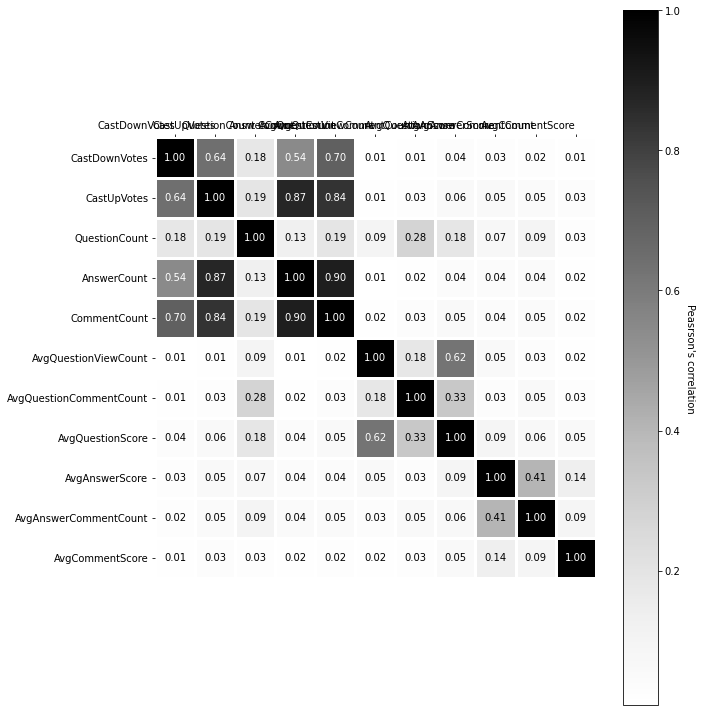

In [ ]:
features = ['CastDownVotes', 'CastUpVotes',
            'QuestionCount', 'AnswerCount', 'CommentCount', 
            
            'AvgQuestionViewCount', 'AvgQuestionCommentCount',
            'AvgQuestionScore', 'AvgAnswerScore',
            'AvgAnswerCommentCount', 'AvgCommentScore',
           ]

#correlation_matrix(raw_dataset[features], figure_size=(20, 8), text_fontsize=8)

fig, ax = plt.subplots(figsize=(10,10))

attributes = ["$A_1$", "$A_2$", "$A_3$", "$A_4$", "$A_5$"]

im, cbar = heatmap(raw_dataset[features].corr(), features, features, ax=ax,
                   cmap="Greys", cbarlabel="Peasrson's correlation")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()

#tikzplotlib.save("attribute_corr.tikz")
fig.savefig('all_attributes_corr.pgf')

plt.show()

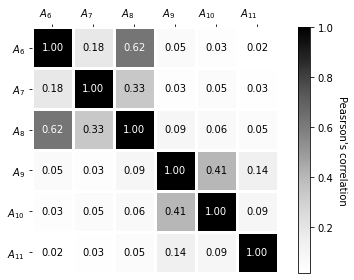

In [ ]:
# content-based attributes
features_content_based = ['AvgQuestionViewCount', 'AvgQuestionCommentCount',
                          'AvgQuestionScore', 'AvgAnswerScore',
                          'AvgAnswerCommentCount', 'AvgCommentScore']

raw_dataset_corr = raw_dataset[features_content_based].copy()
raw_dataset_corr.rename(columns={'AvgQuestionViewCount': 'A_6', 'AvgQuestionCommentCount': 'A_7',
                                 'AvgQuestionScore': 'A_8', 'AvgAnswerScore': 'A_9',
                                 'AvgAnswerCommentCount': 'A_10', 'AvgCommentScore': 'A_11'}, inplace=True)

fig, ax = plt.subplots()

attributes = ["$A_6$", "$A_7$", "$A_8$", "$A_9$", "$A_{10}$", "$A_{11}$"]

im, cbar = heatmap(raw_dataset_corr.corr(), attributes, attributes, ax=ax,
                   cmap="Greys", cbarlabel="Peasrson's correlation")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()

#tikzplotlib.save("attribute_corr.tikz")
fig.savefig('attribute_corr_content_based.pgf')

plt.show()

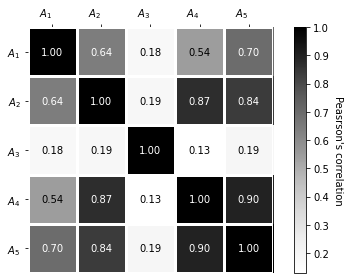

In [ ]:
# behavioural attributes
features_behvavioural = ['CastDownVotes', 'CastUpVotes', 'QuestionCount',
                         'AnswerCount', 'CommentCount']

raw_dataset_corr = raw_dataset[features_behvavioural].copy()
raw_dataset_corr.rename(columns={'CastDownVotes': 'A_1', 'CastUpVotes': 'A_2',
                                 'QuestionCount': 'A_3', 'AnswerCount': 'A_4',
                                 'CommentCount': 'A_5'}, inplace=True)

fig, ax = plt.subplots()

attributes = ["$A_1$", "$A_2$", "$A_3$", "$A_4$", "$A_5$"]

im, cbar = heatmap(raw_dataset_corr.corr(), attributes, attributes, ax=ax,
                   cmap="Greys", cbarlabel="Peasrson's correlation")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()

#tikzplotlib.save("attribute_corr.tikz")
fig.savefig('attribute_corr_behavioural.pgf')

plt.show()

In [ ]:
def f(x):
    if x > 24:
        return 1
    else:
        return 0
    
raw_dataset['disengaged'] = raw_dataset['MonthsSinceLastActivity'].apply(f)

In [ ]:
raw_dataset.head()

,UserId,CreationDate,CastDownVotes,CastUpVotes,ProfileViews,LastAccessDate,QuestionCount,AnswerCount,CommentCount,AvgQuestionViewCount,AvgQuestionFavouriteCount,AvgQuestionCommentCount,AvgQuestionScore,AvgAnswerScore,AvgAnswerCommentCount,AvgCommentScore,MonthsActive,MonthsSinceLastActivity,MonthsSinceJoined,disengaged
0,74,2012-03-06 20:09:16,0,0,0,2012-03-06 20:09:16,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,112,112,1
1,93,2012-03-06 22:11:12,0,0,0,2012-03-06 22:11:12,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,112,112,1
2,109,2012-03-07 01:15:40,0,0,0,2012-03-07 01:15:40,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,112,112,1
3,131,2012-03-07 10:36:39,0,0,1,2012-03-07 10:36:39,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,111,111,1
4,143,2012-03-07 16:21:44,0,2,1,2012-03-07 16:21:44,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,111,111,1


In [ ]:
features = ['CastDownVotes', 'CastUpVotes', 'QuestionCount',
            'AnswerCount', 'CommentCount', #'ProfileViews', 
            'AvgQuestionViewCount', 'AvgQuestionFavouriteCount', 
            'AvgQuestionCommentCount', 'AvgAnswerScore', 
            'AvgCommentScore', 'AvgAnswerCommentCount', 
            "AvgQuestionScore"
           ]

time_column = "MonthsActive"
event_column = "disengaged"

raw_dataset_cut = raw_dataset.copy()[features + [time_column, event_column]]
raw_dataset_cut = raw_dataset_cut[((raw_dataset_cut['QuestionCount'] > 0) | \
                                  (raw_dataset_cut['AnswerCount'] > 0) |
                                  (raw_dataset_cut['CommentCount'] > 0) |
                                  (raw_dataset_cut['CastDownVotes'] > 0) |
                                  (raw_dataset_cut['CastUpVotes'] > 0)) &
                                  (raw_dataset_cut['MonthsActive'] > -1)|
                                  True]

raw_dataset_cut.reset_index(inplace=True)
raw_dataset_cut

,index,CastDownVotes,CastUpVotes,QuestionCount,AnswerCount,CommentCount,AvgQuestionViewCount,AvgQuestionFavouriteCount,AvgQuestionCommentCount,AvgAnswerScore,AvgCommentScore,AvgAnswerCommentCount,AvgQuestionScore,MonthsActive,disengaged
0,0,0,0,0,0,0,0.00,0.0,0.00,0.0000,0.0000,0.0000,0.000,0,1
1,1,0,0,0,0,0,0.00,0.0,0.00,0.0000,0.0000,0.0000,0.000,0,1
2,2,0,0,0,0,0,0.00,0.0,0.00,0.0000,0.0000,0.0000,0.000,0,1
3,3,0,0,0,0,0,0.00,0.0,0.00,0.0000,0.0000,0.0000,0.000,0,1
4,4,0,2,0,0,0,0.00,0.0,0.00,0.0000,0.0000,0.0000,0.000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113428,113428,0,0,0,0,0,0.00,0.0,0.00,0.0000,0.0000,0.0000,0.000,0,0
113429,113429,0,15,8,7,7,37.75,0.0,0.75,0.2857,0.2857,0.5714,0.625,13,0
113430,113430,0,1,1,0,1,31.00,0.0,2.00,0.0000,0.0000,0.0000,0.000,78,0
113431,113431,57,119,2,36,1344,38.50,0.0,0.00,1.0556,0.2433,1.3611,1.500,82,0


In [ ]:
print(raw_dataset_cut[features].describe().to_latex())

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
{} &  CastDownVotes &    CastUpVotes &  QuestionCount &    AnswerCount &   CommentCount &  AvgQuestionViewCount &  AvgQuestionFavouriteCount &  AvgQuestionCommentCount &  AvgAnswerScore &  AvgCommentScore &  AvgAnswerCommentCount &  AvgQuestionScore \\
\midrule
count &  113433.000000 &  113433.000000 &  113433.000000 &  113433.000000 &  113433.000000 &         113433.000000 &              113433.000000 &            113433.000000 &   113433.000000 &    113433.000000 &          113433.000000 &     113433.000000 \\
mean  &       0.282845 &       2.375217 &       0.350815 &       0.412446 &       1.442808 &            172.210642 &                   0.104342 &                 0.435245 &        0.142372 &         0.035946 &               0.079942 &          0.403992 \\
std   &      31.254950 &      94.676645 &       1.743540 &      24.199871 &      69.862164 &           1806.810832 &                   1.114505 &                 1.370530 &        1.3268

In [ ]:
raw_dataset_cut_original = raw_dataset_cut.copy() 
raw_dataset_cut = raw_dataset_cut[features].transform(lambda x: x) #np.log(x+1))
raw_dataset_cut[time_column] = raw_dataset_cut_original[time_column].values
raw_dataset_cut[event_column] = raw_dataset_cut_original[event_column].values

In [ ]:
# Reading the dataset
N = raw_dataset_cut.shape[0]
dataset = raw_dataset_cut

seed = 33

# Building training and testing sets #
index_train, index_test = train_test_split(range(N), test_size = 0.01, random_state=seed)
data_train = dataset.loc[index_train].reset_index(drop=True)
data_test = dataset.loc[index_test].reset_index(drop=True)

# Creating the X, T and E input
X_test = data_test[features]
T_test = data_test[time_column]
E_test = data_test[event_column]

def fit0(model, X_train, T_train, E_train):
    return model.fit(X_train, T_train, E_train, max_features = 'all', max_depth = 5,
    min_node_size = 7, num_threads = -1,
    weights = None, sample_size_pct = 0.63, importance_mode = 'normalized_permutation', seed = seed,
    save_memory=False)

def fit1(model, X_train, T_train, E_train):
    return model.fit(X_train, T_train, E_train,
                     max_features="sqrt", max_depth=5, min_node_size=20)

model = ConditionalSurvivalForestModel(num_trees = 5)

model = RandomSurvivalForestModel(num_trees=5)

# Initializing the KaplanMeierModel
#model = KaplanMeierModel()

# Displaying the survival function and confidence intervals
#display_non_parametric(model)

average_c_index = 0.0
n_fold = 5

kf = KFold(n_splits=n_fold)
for fold, te in enumerate(kf.split(data_train)):
    trainining, evaluation = te
    
    data_train_kf =data_train.loc[trainining].reset_index(drop=True)
    data_eval_kf = data_train.loc[evaluation].reset_index(drop=True)
    
    X_train, X_evaluation = data_train_kf[features], data_eval_kf[features]
    T_train, T_evaluation = data_train_kf[time_column], data_eval_kf[time_column]
    E_train, E_evaluation = data_train_kf[event_column], data_eval_kf[event_column]
    
    fit0(model, X_train, T_train, E_train)
    
    c_index = concordance_index(model, X_evaluation, T_evaluation, E_evaluation)
    print('Fold #{fold} C-index: {:.2f}'.format(c_index, fold=fold))
    
    average_c_index += c_index 
    
    #ibs = integrated_brier_score(model, X_evaluation, T_evaluation, E_evaluation, 
    #                             t_max=30, figure_size=(10, 3))
    #print('Fold #{fold} IBS: {:.2f}'.format(ibs, fold=fold))

print('Average C-index: {:.2f}'.format(average_c_index/n_fold))

Fold #0 C-index: 0.62
Fold #1 C-index: 0.62
Fold #2 C-index: 0.63
Fold #3 C-index: 0.63
Fold #4 C-index: 0.62
Average C-index: 0.63


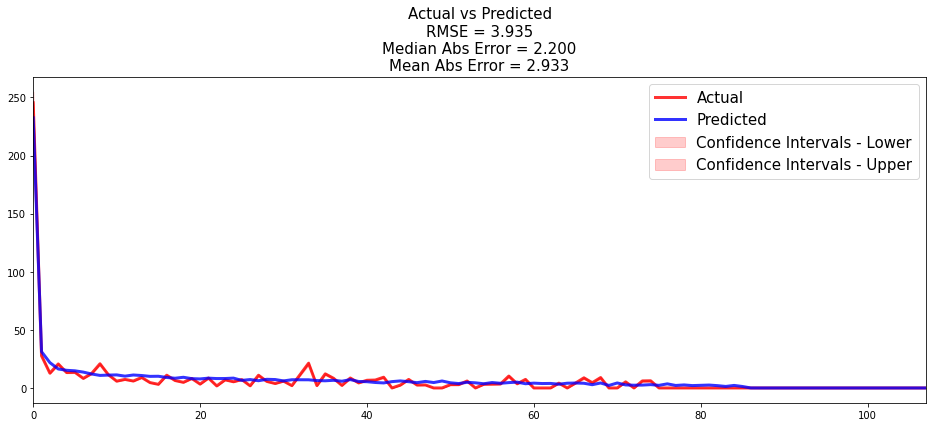

In [ ]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(model, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])

In [ ]:
# from pysurvival.utils.display import create_risk_groups

# risk_groups = create_risk_groups(model=model, X=X_test,
#     use_log = False, num_bins=20, figure_size=(20, 4),
#     low={'lower_bound':0, 'upper_bound':20, 'color':'green'},
#     medium={'lower_bound':20, 'upper_bound':60.,'color':'blue'},
#     high={'lower_bound':60, 'upper_bound':120,  'color':'red'})

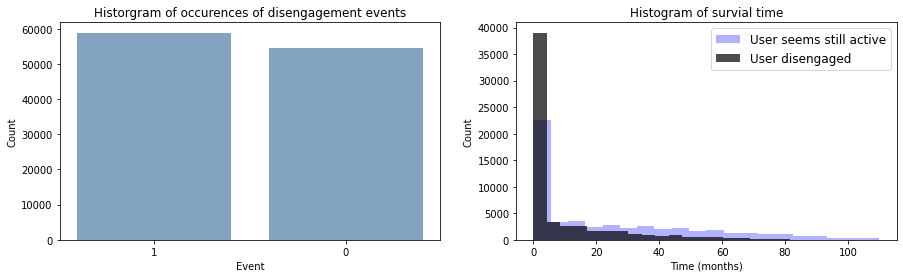

In [ ]:
from collections import Counter

# Creating an empty chart
fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

# Counting the number of occurrences for each category 
data = Counter(raw_dataset['disengaged'])
category = list(data.keys())
counts = list(data.values())
idx = range(len(counts))

# Displaying the occurrences of the event/censoring
ax1.bar(idx, counts, color=(0.2, 0.4, 0.6, 0.6))
#ax1.bar(["disengaged", "censored"], [13584, 17657])
ax1.set_xticks(idx)
ax1.set_xticklabels(category)
ax1.set_title('Historgram of occurences of disengagement events', fontsize=12)
ax1.set_xlabel("Event")
ax1.set_ylabel("Count")

# Showing the histogram of the survival times for the censoring
time_0 = raw_dataset.loc[raw_dataset['disengaged'] == 0, 'MonthsActive']
ax2.hist(time_0, bins=20, alpha=0.3, color='blue', label = 'User seems still active')

# Showing the histogram of the survival times for the events
time_1 = raw_dataset.loc[raw_dataset['disengaged'] == 1, 'MonthsActive']
ax2.hist(time_1, bins=20, alpha=0.7, color='black', label = 'User disengaged')
ax2.set_title('Histogram of survial time', fontsize=12)
ax2.set_xlabel("Time (months)")
ax2.set_ylabel("Count")

# Displaying everything side-by-side
plt.legend(fontsize=12)
#tikzplotlib.save("observation_period_not_last36.tikz")
plt.savefig('observation_period_not_last24.pdf')

plt.show()

In [ ]:
# for feature in features:

#     # Creating an empty chart
#     fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(12, 5))

#     # Extracting the feature values
#     x = raw_dataset_cut_original[feature].values

#     # Histogram
#     ax1.hist(x, bins=10)
#     ax1.set_title( 'Histogram for {}'.format(feature))
    
#     # Logged Histogram
#     ax2.hist(np.log(x+20), bins=10)
#     ax2.set_title( 'Histogram for log-transformed {}'.format(feature))
    
#     # Boxplot
#     #ax3.boxplot(np.log(x+1))
#     #ax3.set_title( 'Boxplot for {}'.format(feature))

#     # Display
#     plt.show()

In [ ]:
from operator import itemgetter

d = model.variable_importance

# feature importance based on 'nornalised permutation'
sorted(d.items(), key=itemgetter(1), reverse=True)

[('CastUpVotes', 135.92651369375366),
 ('CommentCount', 13.313893577236929),
 ('AvgQuestionViewCount', 5.51617728390032),
 ('QuestionCount', 2.7514893656205643),
 ('AvgAnswerScore', 2.3176424118309473),
 ('AvgCommentScore', 2.0003990410555654),
 ('AvgQuestionScore', 1.867698429297288),
 ('AnswerCount', 1.3238012436121478),
 ('AvgQuestionCommentCount', 1.0737599822702373),
 ('CastDownVotes', 0.0),
 ('AvgQuestionFavouriteCount', 0.0),
 ('AvgAnswerCommentCount', -1.4062773986132042)]

In [ ]:
model.variable_importance_table

,feature,importance,pct_importance
0,CastUpVotes,135.926514,0.818384
1,CommentCount,13.313894,0.080160
2,AvgQuestionViewCount,5.516177,0.033212
3,QuestionCount,2.751489,0.016566
4,AvgAnswerScore,2.317642,0.013954
5,AvgCommentScore,2.000399,0.012044
6,AvgQuestionScore,1.867698,0.011245
7,AnswerCount,1.323801,0.007970
8,AvgQuestionCommentCount,1.073760,0.006465
9,CastDownVotes,0.000000,0.000000


NameError: name 'risk_groups' is not defined

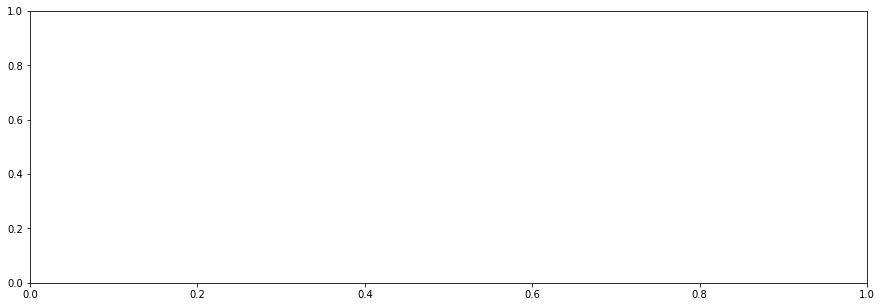

In [ ]:
# Initializing the figure
fig, ax = plt.subplots(figsize=(15, 5))

# Selecting a random individual that experienced an event from each group
groups = []
for i, (label, (color, indexes)) in enumerate(risk_groups.items()) :

    # Selecting the individuals that belong to this group
    if len(indexes) == 0 :
        continue
        
    X = X_test.values[indexes, :]
    T = T_test.values[indexes]
    E = E_test.values[indexes]

    # Randomly extracting an individual that experienced an event
    choices = np.argwhere((E==1.)).flatten()
    if len(choices) == 0 :
        continue
        
    k = np.random.choice(choices, 1)[0]

    # Saving the time of event
    t = T[k]

    # Computing the Survival function for all times t
    survival = model.predict_survival(X[k, :]).flatten()

    # Displaying the functions
    label_ = '{} risk'.format(label)
    plt.plot(model.times, survival, color = color, label=label_, lw=2)
    groups.append(label)

    # Actual time
    plt.axvline(x=t, color=color, ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5*(1.+0.2*i)),
                xytext=(t, 0.5*(1.+0.2*i)), fontsize=12)

# Show everything
groups_str = ', '.join(groups)
title = "Comparing Survival functions between {} risk grades".format(groups_str)
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5b875ec7-933b-4a3a-92bc-cefd5e08f9f6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>